# RSCAM Assessment 3


# Simulating Langevin dynamics

We assume we have some complicated potential energy function $U(q)$, and the target distribution $\rho_\beta(q)$ where
$$\rho_\beta(q) = \frac1{Z_\beta} \exp(-\beta U(q)),\qquad Z_\beta=\int_{-\infty}^\infty \exp(-\beta U(q) )\,\rm{d}q.$$
Ultimately we want to compute averages with respect to this distribution, which we can write as an integral against $\rho_\beta(q)$.

If we augment our distribution to include momentum $p$, then we can write
$$\rho_\beta(q,p) = \frac1{\hat{Z}_\beta} \exp(-\beta H(q,p) ),\qquad \hat{Z}_\beta=\int_{-\infty}^\infty \exp(-\beta H(q,p) )\,\rm{d}q\rm{d}p,$$
where $H$ is the familiar Hamiltonian, or total energy function, that we've seen before
$$H(q,p) = \frac12 \|p\|^2 + U(q)$$
where we have assumed mass is 1 for all degrees of freedom.   (It is easy to change this if we wanted to include a nonunit mass, but just complicates the notation a bit.)

As $q$ and $p$ are independent, we can integrate out over the momentum variables and recover the correct sampling in $q$.  This means that we can think of the momenta as intermediate or 'auxiliary' variables if our main goal is to compute averages of q-dependent functions.

The momentum variables are useful as they can allow a system to continue going in an unfavourable direction (i.e. up barriers) via inertia. This property is lacking in, for example, Brownian dynamics.

The equations of motion for Langevin dynamics are
$${ \begin{array}{rcl}
\dot{q} &=& p\\
\dot{p} &=& -\nabla U(q) - \gamma p + \sqrt{2\gamma /\beta} \dot{W}\end{array}}$$
where $W$ is a Wiener process, and $\gamma>0$ is the _friction constant_, a parameter that describes how rapidly energy is dissipated from the system to its surroundings as well as the rate at which the momentum is randomized ($\gamma$ should be viewed as a rate). Note that if $\gamma=0$ then the system reduces to the constant energy (Hamiltonian) dynamics that we looked at earlier in the term when we studied symplectic methods. If $\gamma$ is large, or infinite, then solutions will tend towards solutions to Brownian dynamics, as mentioned in lecture.   In between, $\gamma$ alters the way we converge to equilibrium (or the rate at which averages of functions taken along stochastic paths converge to their long term (ensemble) averages.

We can rewrite Langevin dynamics as the sum of three terms:


$$\left[ \begin{array}{c} \dot{q}\\ \dot{p} \end{array}\right]
= \underbrace{\left[\begin{array}{c} p \\0 \end{array}\right]}_\text{A}
+ \underbrace{\left[\begin{array}{c} 0\\F(q) \end{array}\right]}_\text{B}
+ \underbrace{\left[\begin{array}{c} 0\\-\gamma p + \sqrt{2\gamma/\beta} \dot{W} \end{array}\right]}_\text{O}.$$
As usual $F(q)=-\nabla U(q)$ denotes the force.

As discussed in lecture, we can solve each of the pieces _exactly_ in the weak (distributional) sense:

$$\text{(A) dynamics step}$$
$$ \left| \begin{array}{rcl}
q(t+h)&\leftarrow&q(t) + h  p(t) \\
\qquad p(t+h)&\leftarrow&p(t)
\end{array}\right.$$

$$\text{(B) dynamics step}$$
$$ \left| \begin{array}{rcl}
q(t+h)&\leftarrow&q(t) \\
\qquad p(t+h)&\leftarrow&p(t) + h F(q(t))
\end{array}\right.$$

$$\text{(O) dynamics step}$$
$$ \left| \begin{array}{rcl}
q(t+h)&\leftarrow&q(t) \\
R(t+h)&\leftarrow& \text{Normal}(0,I)\\
\qquad p(t+h)&\leftarrow&\exp(-\gamma h) p(t) + \sqrt{1/\beta}\sqrt{1-\exp(-2\gamma h)} R(t+h)
\end{array}\right.$$

The solution of the O step comes from the solution for the Ornstein-Uhlenbeck process, with $R(t)\in\mathbb{R}^N$ a vector of independent and identically distributed (i.i.d.) normal random numbers.

In [ ]:
import numpy as np
from functools import partial
import matplotlib.pyplot as plt
from IPython.display import HTML
from scipy.integrate import quad
import pandas as pd
plt.rc('font', size=14) # makes the fonts used in graphs a bit larger (and clearer)!

In [ ]:
def A_step( qp , h ):
    q,p = qp

    q = q + h*p

    return [q,p]

def B_step( qp , h, force ):
    q,p = qp

    F = force(q)

    p = p + h * force(q)

    return [q,p]

def O_step( qp , h,gamma, beta ):
    q,p = qp

    alpha = np.exp(-h*gamma)
    beta = np.sqrt(1/beta)
    sigma = np.sqrt(1-np.exp(-2*gamma * h))

    R = np.random.randn( q.size ).reshape( q.shape)
    p = alpha * p + beta * sigma * R

    return [q,p]

Next we can define a method integrating Langevin Dynamics by performing these steps in sequence. For example, the _ABO_ method looks like this:

In [ ]:
def ld_ABO(q,p,h,gamma,beta,force):

    # The algorithm "ABO" does A then B then O

    qp = np.copy([q,p])  #this just translates the separate q and p vectors
                #into a single vector composed from the pair.

    qp = A_step(qp, h)
    qp = B_step(qp, h, force)
    qp = O_step(qp, h, gamma, beta)
    q,p = qp

    return q , p

We can feed this function into the `run_simulation` function  (see below) as the 'step_function' argument. Note that beta, the reciprocal temperature parameter, must be fed through the functions together with gamma.

In [ ]:
def run_simulation(q0,p0, Nsteps, h, gamma, beta, step_function, force_function):

    q_traj = [np.copy(q0)]
    p_traj = [np.copy(p0)]
    t_traj = [0]

    q = np.copy(q0)
    p = np.copy(p0)
    t = 0

    for n in range(Nsteps):
        q,p = step_function(q, p, h, gamma, beta, force_function)
        t = t + h

        q_traj += [q]
        p_traj += [p]
        t_traj += [t]

    q_traj = np.array(q_traj)
    p_traj = np.array(p_traj)
    t_traj = np.array(t_traj)

    return q_traj, p_traj, t_traj

In discussing the evolving distribution associated to the numerical method, one normally thinks of taking a large number of separate sampling paths and using the snapshots of them at a given time as a discrete approximation to the evolving probability distribution.

On the other hand, if one is interested in the long term averages, it is not necessary to use this approach.   Rather than taking many walkers and looking at the evolving distributions, one may run a single, long simulation. It can be shown that taking averages over this long simulation is equivalent to looking at the large time limit of lots of walkers, i.e. time averages along a trajectory will still equal averages with respect to the target distribution.

For example, for a Gaussian we can look at the sampled distributions generated by a single path as follows:

In [ ]:
def force_Gaussian(q):
    # U(q) = q^2 /2
    F = -q
    return F

# Initialize one walker from a Gaussian distribution

q0 = np.random.randn(1)
p0 = np.random.randn(1)

Nsteps = 10000
h = 0.5
gamma = 1.0
beta = 1.0

# Run one long trajectory of Nsteps, using the ABO scheme
q_traj, p_traj, t_traj = run_simulation(q0, p0, Nsteps , h, gamma, beta, ld_ABO, force_Gaussian)

And then plot the resulting trajectories of the $q$ variable and the distributions marginalised in $q$ and $p$:

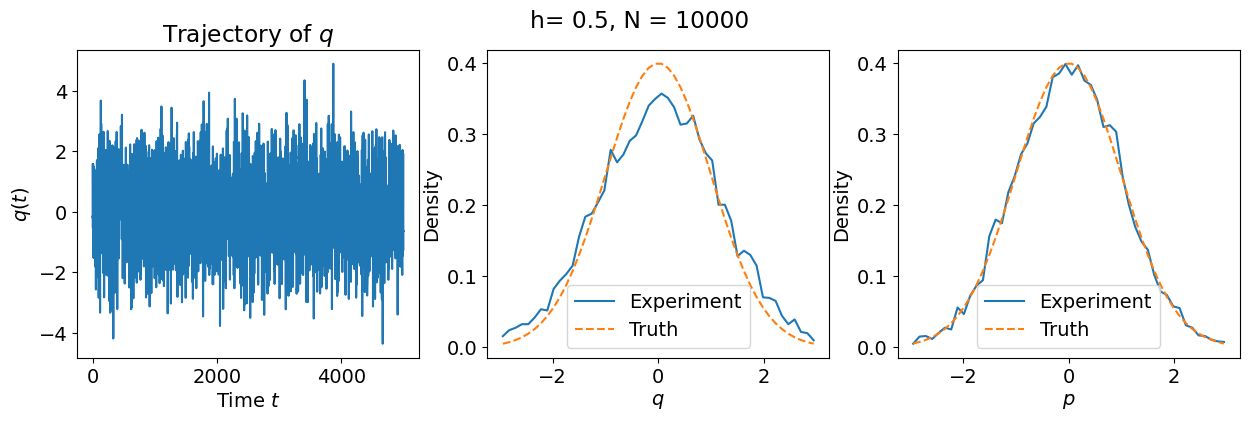

In [ ]:
def plot_1(q_traj, p_traj, t_traj, h, Nsteps):
    fig = plt.figure(figsize=[15,4])

    plt.subplot(1,3,1)
    plt.plot( t_traj, q_traj )
    plt.title('Trajectory of $q$')
    plt.ylabel('$q(t)$')
    plt.xlabel('Time $t$')

    plt.subplot(1,3,2)
    histogram,bins = np.histogram(q_traj,bins=50,range=[-3,3], density=True)
    midx = (bins[0:-1]+bins[1:])/2
    rho = np.exp(- beta*(midx**2)/2)
    rho = rho / ( np.sum(rho) * (midx[1]-midx[0]) ) # Normalize rho by dividing by its approx. integral
    plt.plot(midx,histogram,label='Experiment')
    plt.plot(midx,rho,'--',label='Truth')
    plt.xlabel('$q$')
    plt.ylabel('Density')
    plt.legend()

    plt.subplot(1,3,3)
    histogram,bins = np.histogram(p_traj,bins=50,range=[-3,3], density=True)
    midx = (bins[0:-1]+bins[1:])/2
    rho = np.exp(- beta*(midx**2)/2)
    rho = rho / ( np.sum(rho) * (midx[1]-midx[0]) ) # Normalize rho by dividing by its approx. integral
    plt.plot(midx,histogram,label='Experiment')
    plt.plot(midx,rho,'--',label='Truth')
    plt.xlabel('$p$')
    plt.ylabel('Density')
    plt.suptitle(f'h= {h}, N = {Nsteps}')
    plt.legend()
    plt.show()

plot_1(q_traj, p_traj, t_traj, h = h, Nsteps = Nsteps)

Discuss the gap between the distribution of points generated by the numerical method and the exact, true Gaussian distribution.   

$\mathbf{q}$ represents the trajectory of the particle while $\mathbf{p}$ represents the momentum.

## For the distribution of $\mathbf{q}$, the blue curve represents the sampled trajectory while the orange curve represents its true underlying trajectory that we would ideally like to recover. There is a gap now because it needs to run for longer. The longer it runs (assuming reasonable stepsize), the closer it will converge. Right now, the tails look heavier as it might be spending more time in the transition states.

## For the distribution of $\mathbf{p}$, the blue curve represents the momentum of our sampling particle while the orange curve represents the true underlying momentum distribution that we would ideally like to recover. The gap appears to be smaller than that for the distribution of $\mathbf{q}$.

## Note that the orange curve is the Gaussian distribution. With many more samples, the distributions of our sampled $\mathbf{q}$ and sampled $\mathbf{p}$ should approach this.

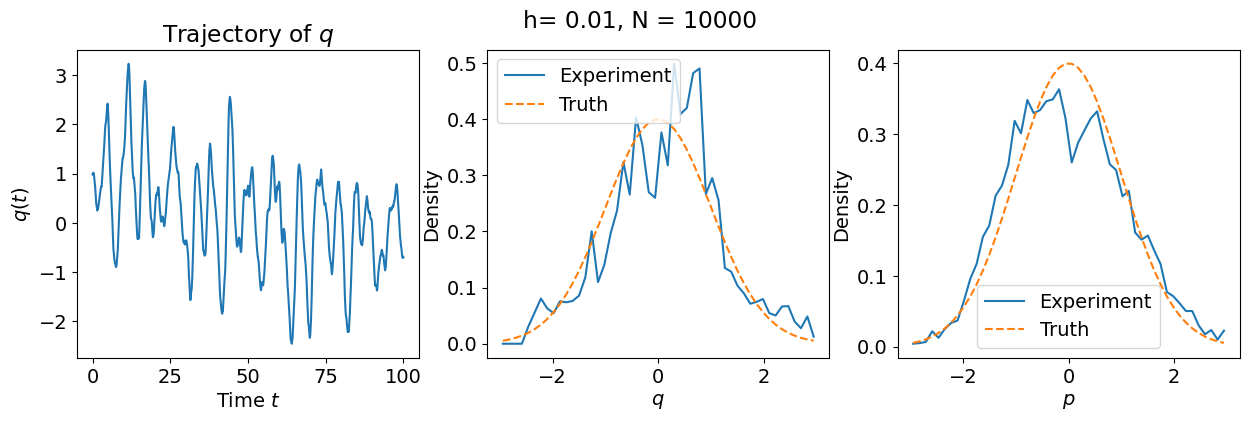

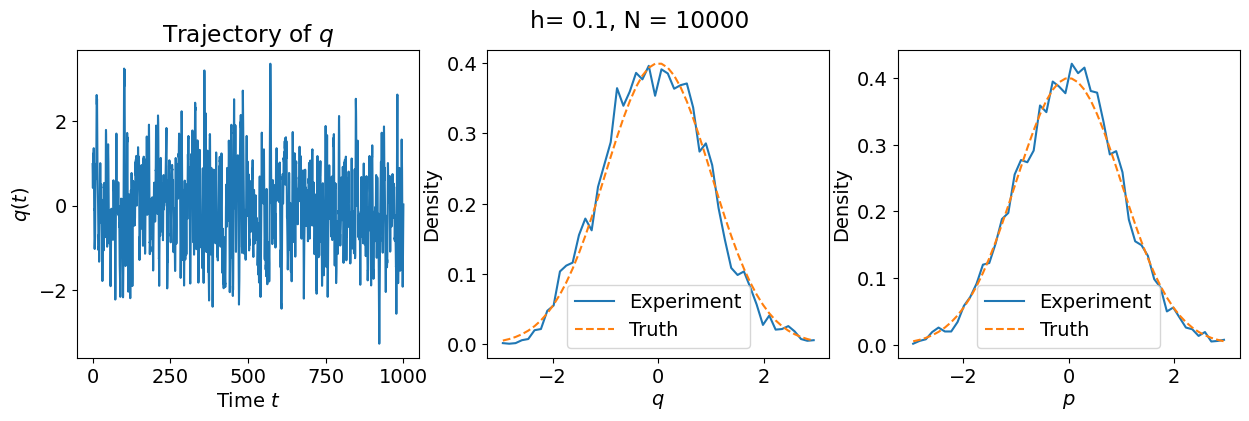

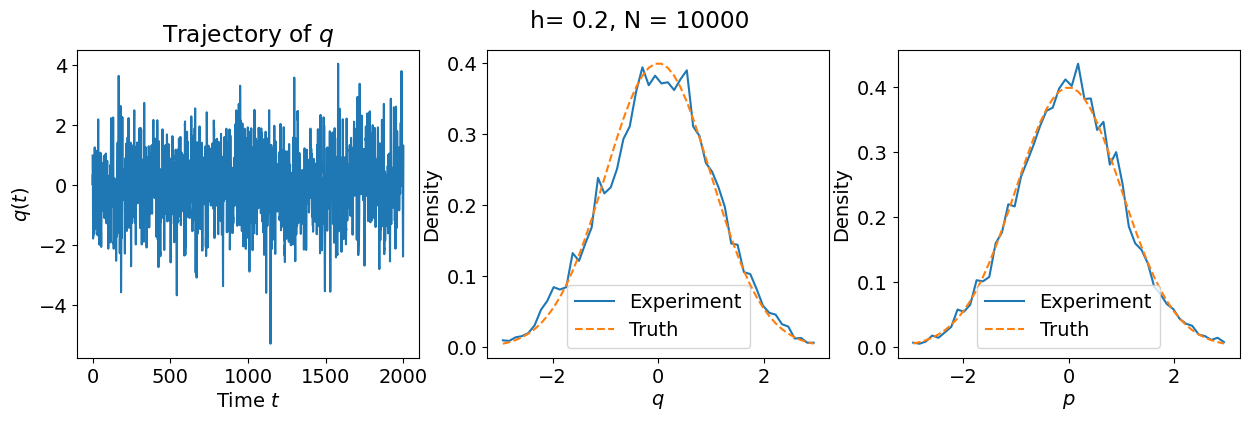

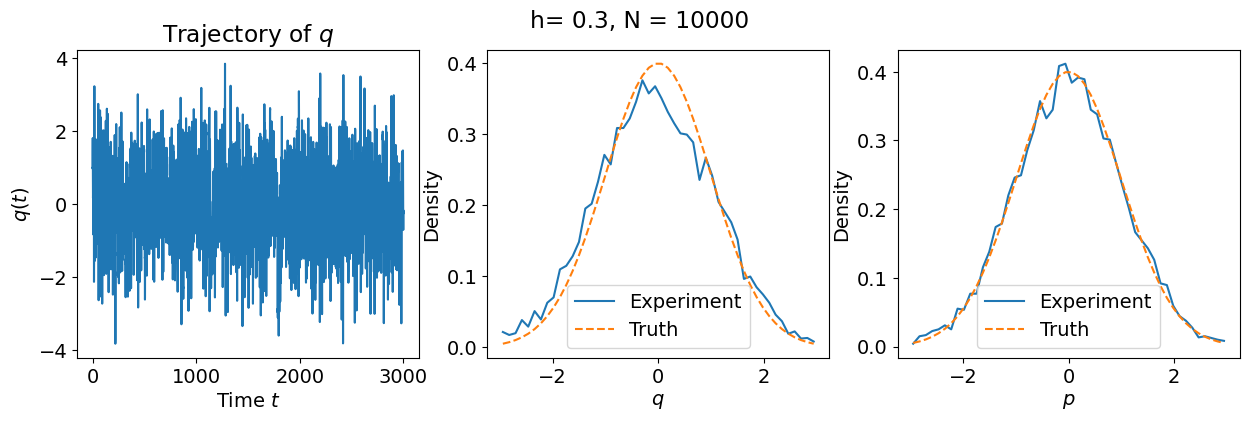

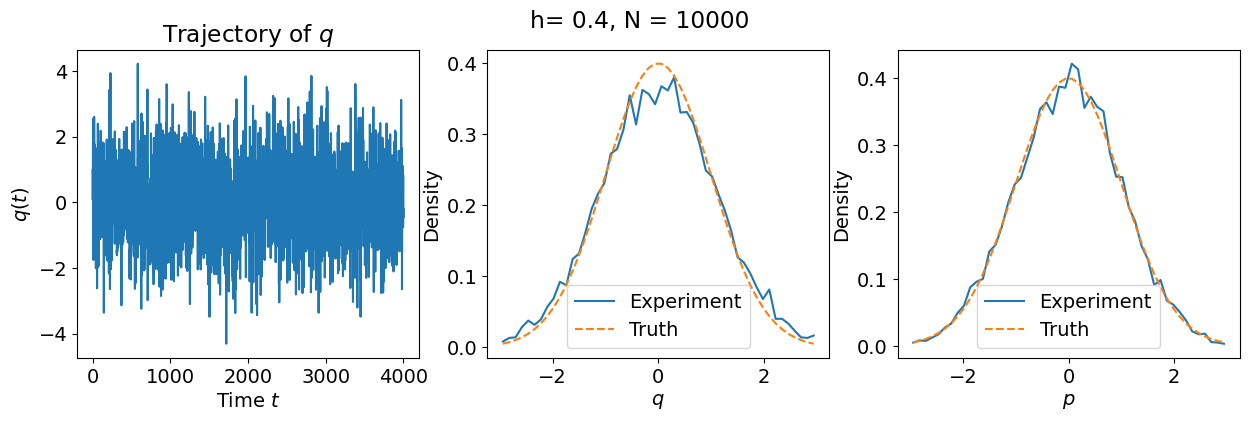

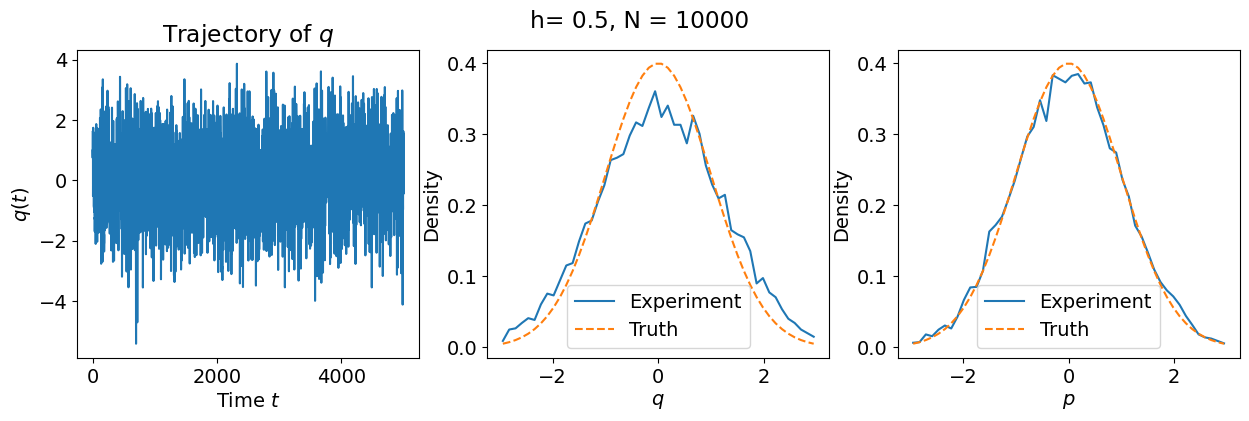

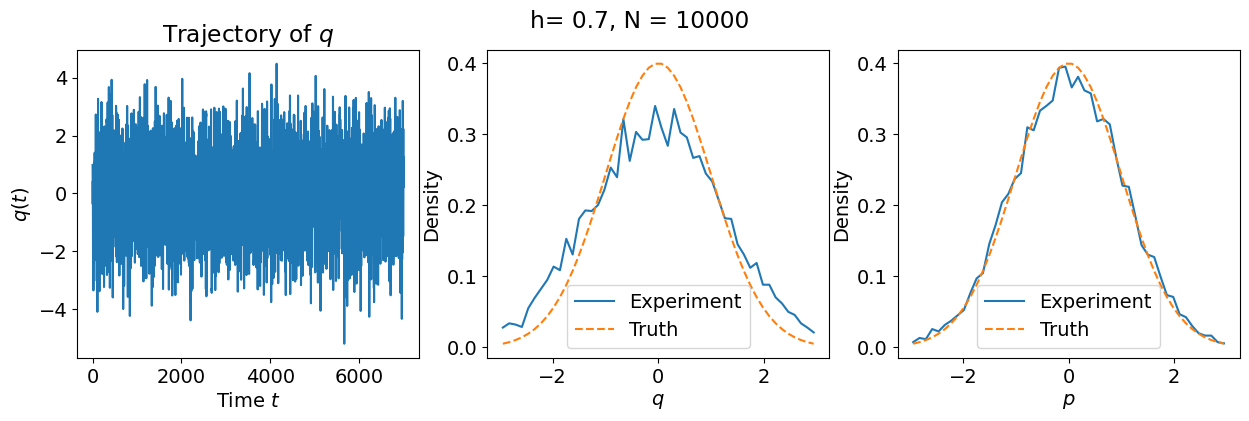

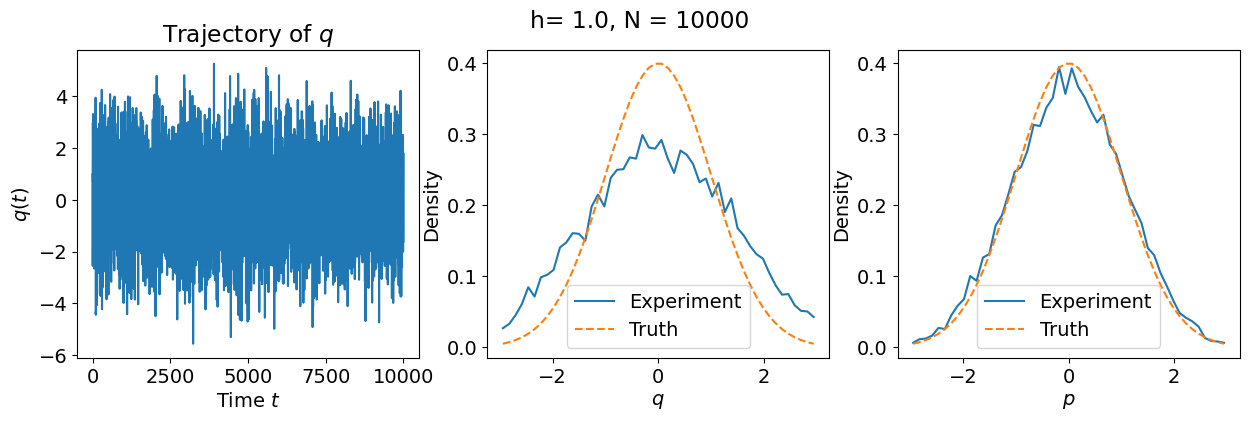

In [ ]:
hs = [0.01, 0.1, 0.2, 0.3,0.4,0.5,0.7,1.0]
Nsteps = 10000
for h in hs:
    q_traj, p_traj, t_traj = run_simulation(q0, p0, Nsteps , h, gamma, beta, ld_ABO, force_Gaussian)
    plot_1(q_traj, p_traj, t_traj, h=h, Nsteps = Nsteps)

## **Discussion:** We observe that from 0.1, as we increase the value of stepsize, the tails of our sampled distribution get heavier and heavier. This is because of the discretization error which depends mainly on the stepsize. A larger stepsize typically means more error. However, we notice that for h = 0.01, despite being smaller than 0.1, does much worse than that at h = 1.0 even. It does not resemble a Gaussian distribution at all. This is likely because for h = 0.01, the issue is that we only run it for t = 100 which is a very short time. This might be considered the "burn-in period" even. This issue applied to other sizes of h as well. The larger stepsizes have the advantage of being simulated for much larger time. Thus, we will re-run our experiment but keep the time consistent at t = 10000 this time.

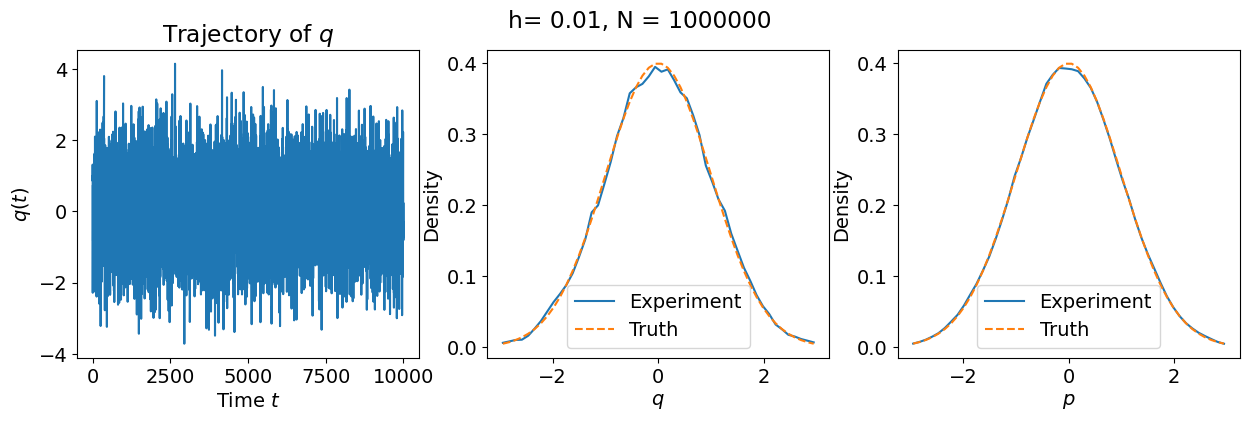

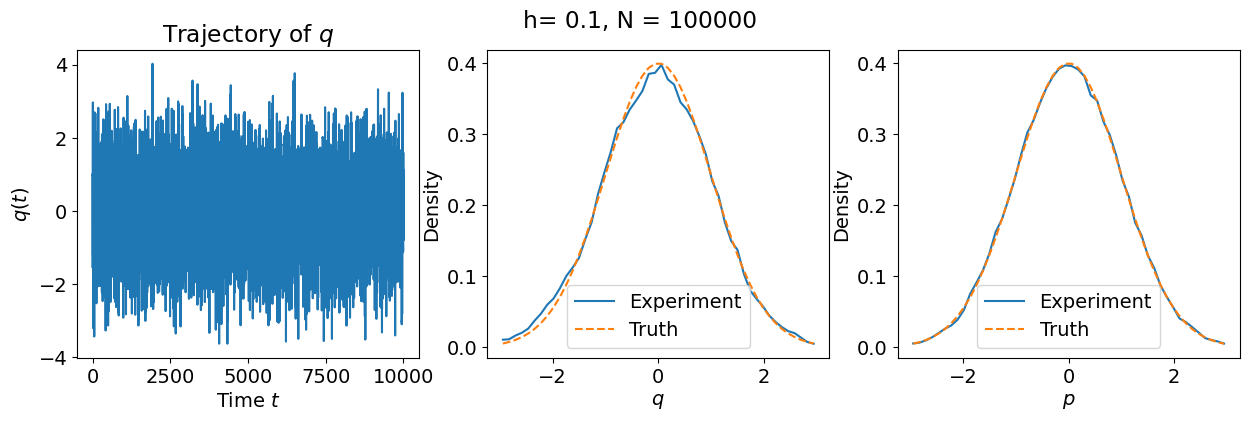

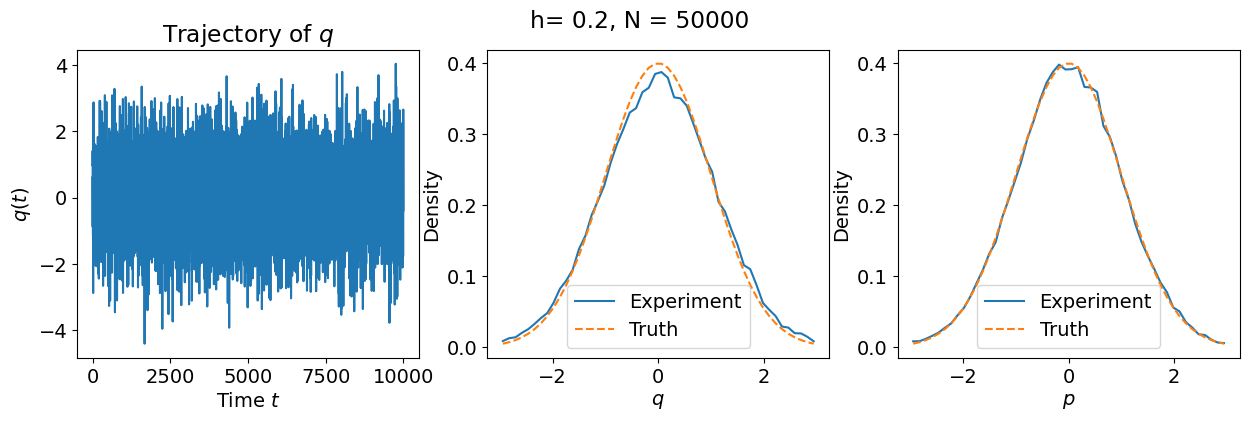

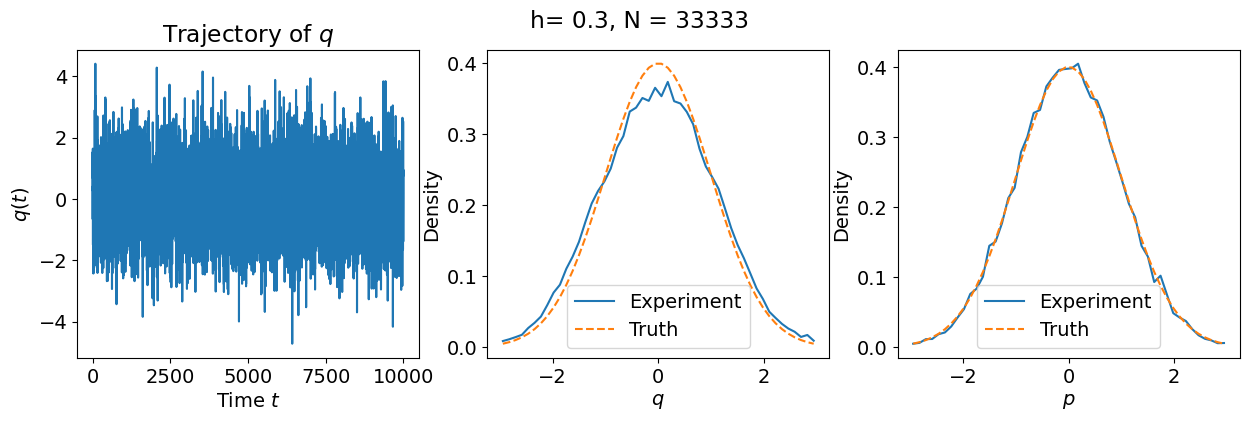

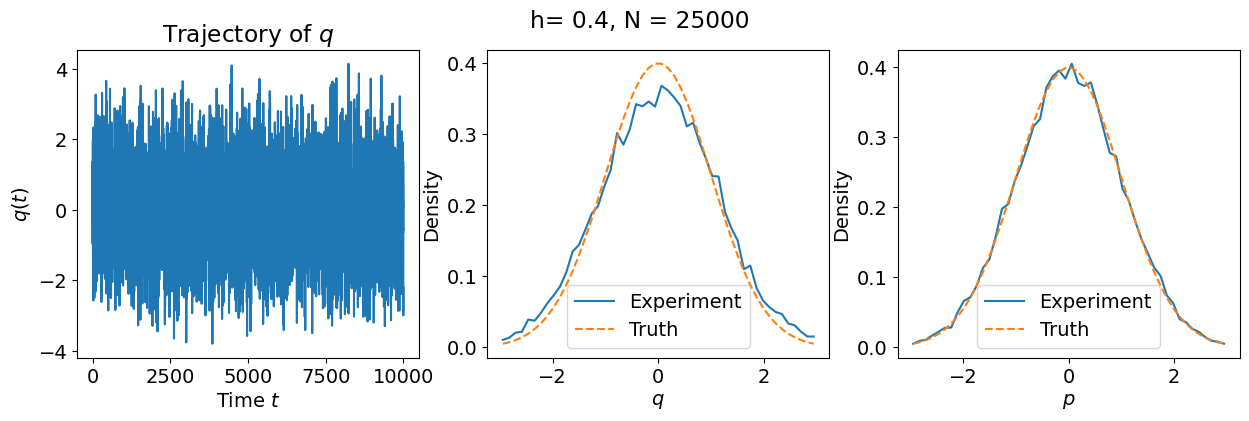

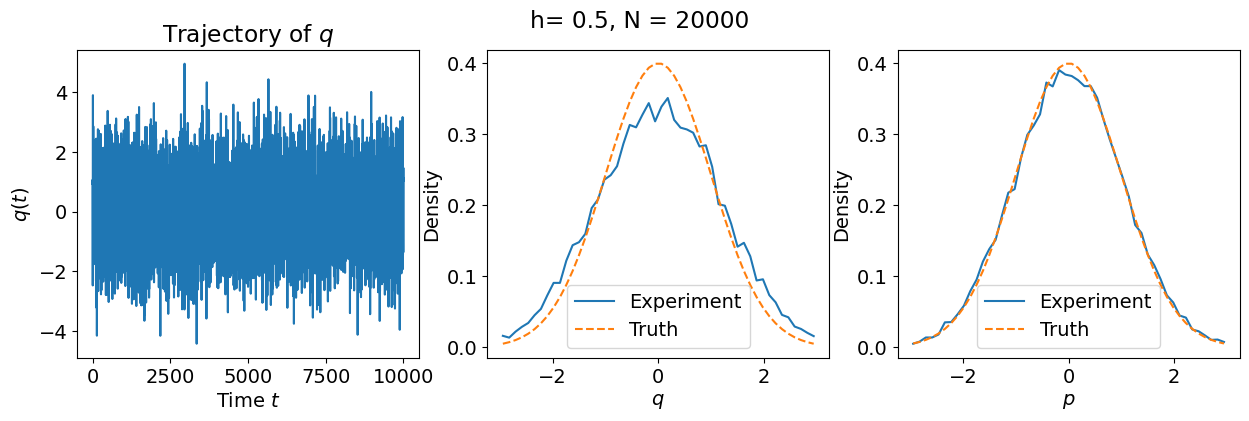

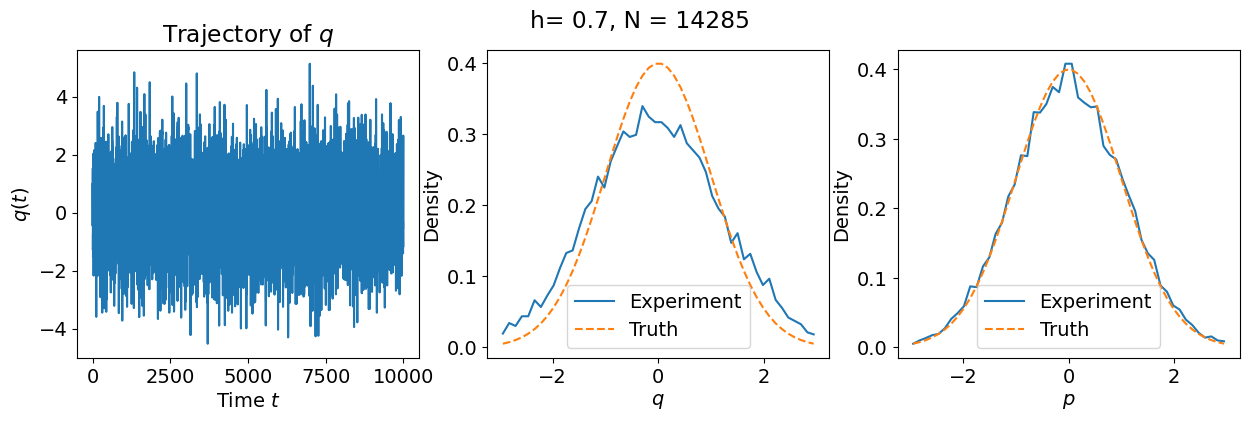

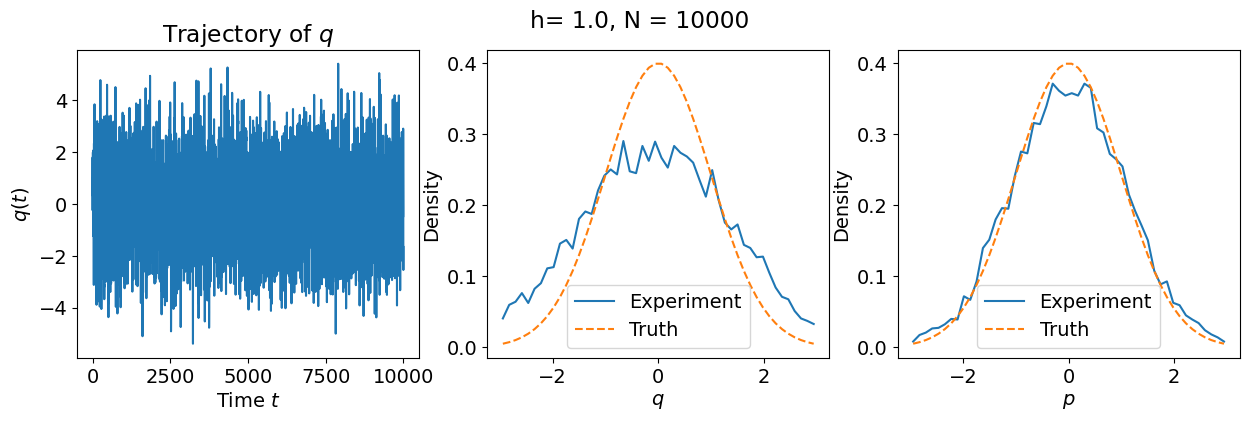

In [ ]:
hs = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 1.0]
t = 10000
for h in hs:
    Nsteps = int(t * 1/h)
    q_traj, p_traj, t_traj = run_simulation(q0, p0, Nsteps , h, gamma, beta, ld_ABO, force_Gaussian)
    plot_1(q_traj, p_traj, t_traj, h=h, Nsteps = Nsteps)

## **Discussion:** We now observe that h=0.01 has the largest accuracy while h = 1.0 has the smallest, deduced qualitatively by eye. This makes sense as when time is fixed and stepsize is varied, the smaller stepsizes tend to have a smaller discretization error. The momentum $p$ is sampled almost perfectly. There still appear to be some kinks to be ironed out in q. I suspect that if we account for burnin error and reduce the stepsize further, we can achieve a near exact convergence to the true Gaussian distribution.

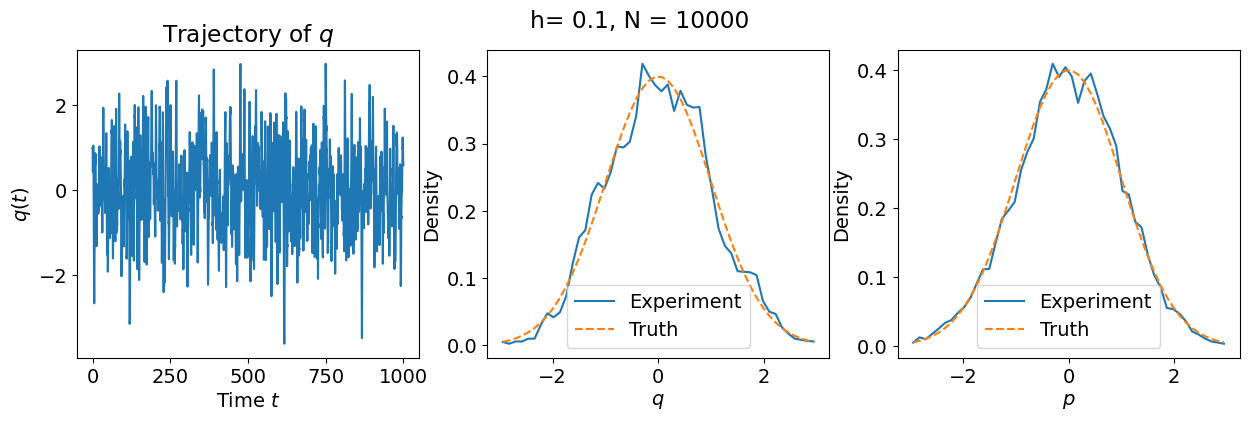

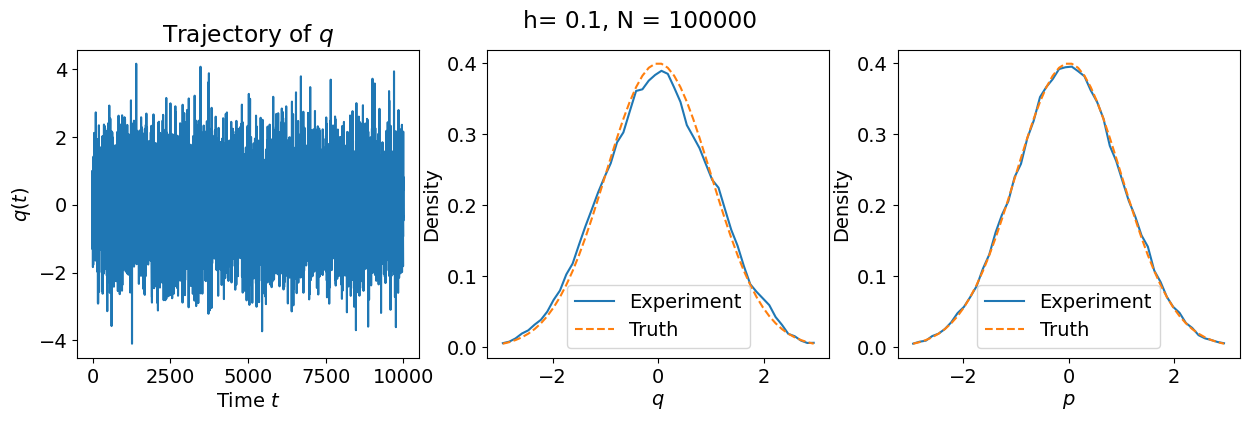

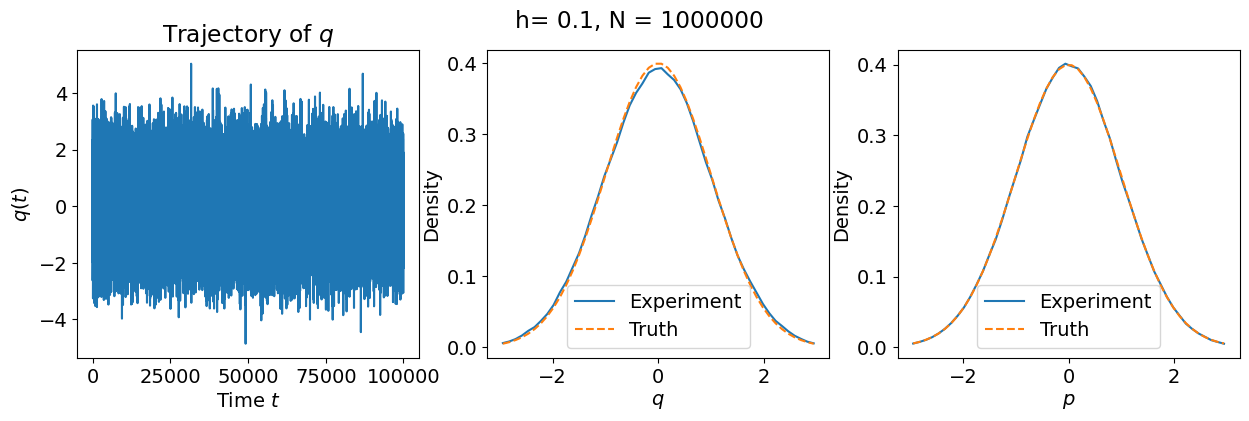

In [ ]:
h = 0.1
Nstepss = [10000, 100000, 1000000]
for Nsteps in Nstepss:
    q_traj, p_traj, t_traj = run_simulation(q0, p0, Nsteps , h, gamma, beta, ld_ABO, force_Gaussian)
    plot_1(q_traj, p_traj, t_traj, h = h, Nsteps = Nsteps)

## **Discussion:** Now, we vary the number of steps while keeping h fixed. This highlight the issue I referred to from the first experiment. Despite having the same stepsize, if it runs for larger time t, it will converge to the true distribution more closely. We observe that for Nsteps = 1e6, the sampled momentum distribution p converges exactly while the sampled trajectory distribution q is quite close but appears to have slighlty heavier tails. The kinks don't appear to be too prevalent. The sampled distribution is quite smooth.

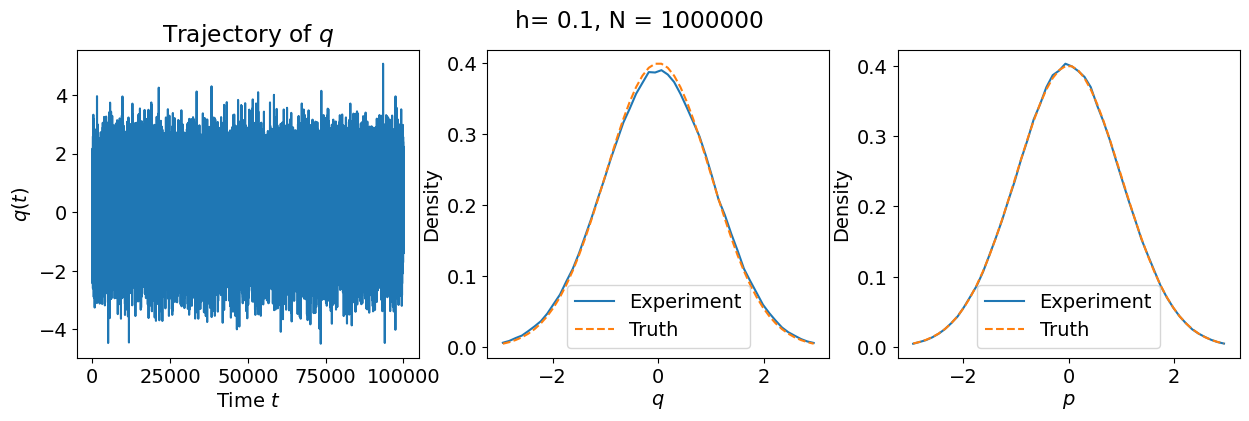

In [ ]:
Nsteps = 1000000
h = 0.1
q_traj, p_traj, t_traj = run_simulation(q0, p0, Nsteps , h, gamma, beta, ld_ABO, force_Gaussian)
burnin = 1000
plot_1(q_traj[burnin:], p_traj[burnin:], t_traj[burnin:], h = h, Nsteps = Nsteps)

## **Discussion:** I posited that the kink may be due to burn-in, so I simulated the experiment for Nsteps = 1e6 again but set burnin = 1000 samples. This did not seem to help much unfortunately.

In [ ]:
def ld_BAOAB(q,p,h,gamma,beta, force):

    qp = np.copy([q,p])
    # your code goes here!
    qp = B_step(qp, h/2, force)
    qp = A_step(qp, h/2 )
    qp = O_step(qp, h, gamma, beta )
    qp = A_step(qp, h/2 )
    qp = B_step(qp, h/2, force)

    q,p = qp

    return q , p

Compare the exact distribution to sampled distributions computed using  _BAOAB_ by making plots of their q trajectories and q and p marginal densities (as done above for the Gaussian case). Compute distributions in both configurations ($q$) and momenta ($p$), for the potential energy function shown below. Use Nsteps = 10000, a stepsize of $h=0.1$, $\gamma=1$, and $\beta=1.0$
$$U(q) = q^2(.1+\sin^2(q))$$

*(Run using one path for a long enough simulation so that your histogram looks smooth. Include axis labels, legends and titles where necessary.)*

In [ ]:
def my_pot(q):
    U= (q**2)*(np.sin(q)**2 +0.1)
    return U

def my_force(q):
    F = -2*q*(np.sin(q)**2 +0.1) - 2*q**2*np.sin(q)*np.cos(q)
    return F

In [ ]:
def plot_4(q_traj, p_traj, t_traj, Nsteps, h):
    fig = plt.figure(figsize=[15,4])

    plt.subplot(1,3,1)
    plt.plot( t_traj, q_traj )
    plt.title('Trajectory of $q$')
    plt.ylabel('$q(t)$')
    plt.xlabel('Time $t$')

    plt.subplot(1,3,2)
    histogram,bins = np.histogram(q_traj,bins=100,range=[-5,5], density=True)
    midx = (bins[0:-1]+bins[1:])/2
    rho = np.exp(-beta*my_pot(midx))
    rho = rho / (np.sum(rho) * (midx[1]-midx[0])) # Normalize rho by dividing by its approx. integral
    plt.plot(midx,histogram,label='Experiment')
    plt.plot(midx,rho,'--',label='Truth')
    plt.title(f'Nsteps= {Nsteps}, h = {h}')
    plt.xlabel('$q$')
    plt.ylabel('Density')
    plt.legend()

    plt.subplot(1,3,3)
    histogram,bins = np.histogram(p_traj,bins=50,range=[-3,3], density=True)
    midx = (bins[0:-1]+bins[1:])/2
    rho = np.exp(- beta*(midx**2)/2)
    rho = rho / (np.sum(rho) * (midx[1]-midx[0])) # Normalize rho by dividing by its approx. integral
    plt.plot(midx,histogram,label='Experiment')
    plt.plot(midx,rho,'--',label='Truth')
    plt.xlabel('$p$')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

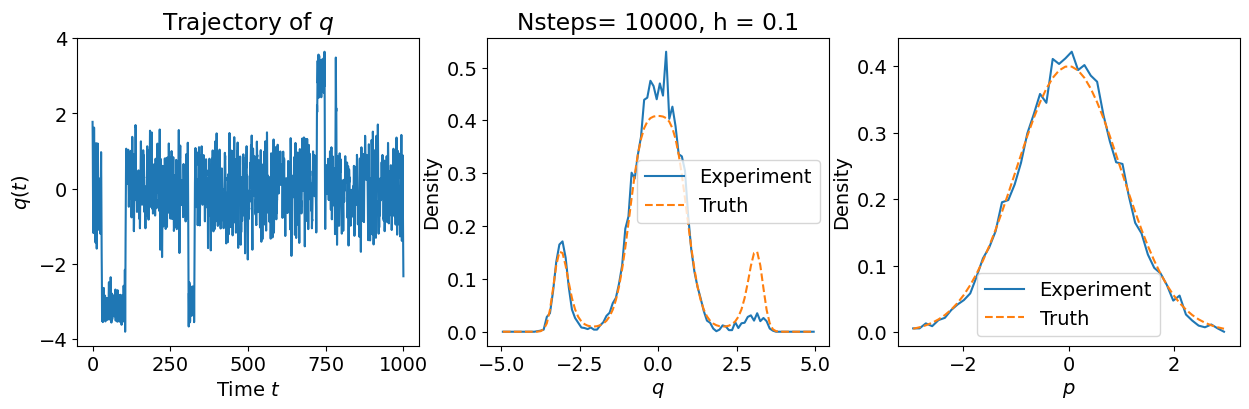

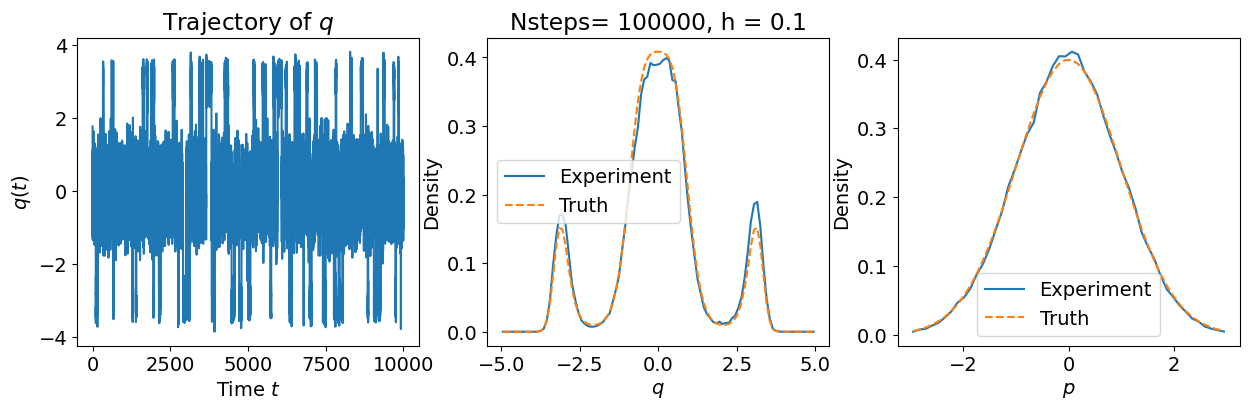

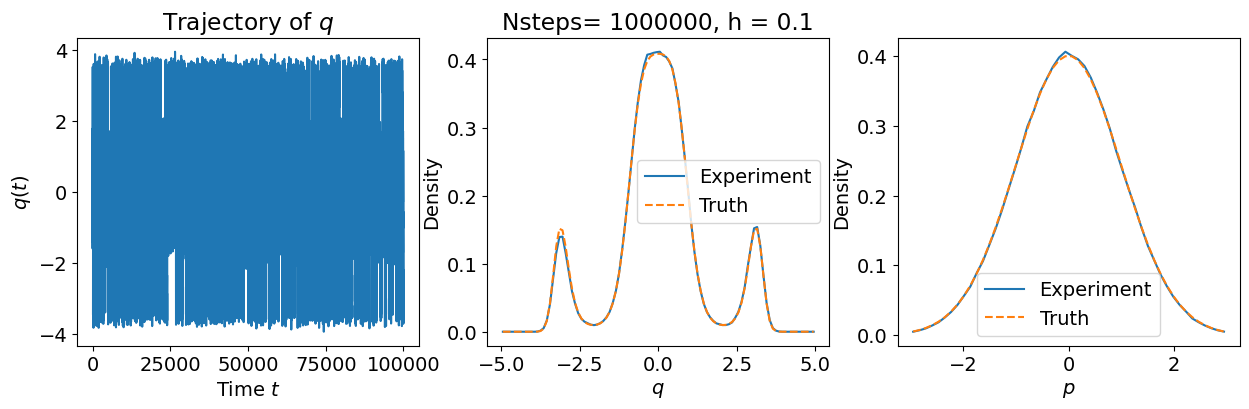

In [ ]:
## your work here!
Nstepss = [10000, 100000, 1000000]
q0, p0, h, gamma, beta = np.random.randn(1), np.random.randn(1), 0.1, 1, 1.0
for Nsteps in Nstepss:
    q_traj, p_traj, t_traj = run_simulation(q0, p0, Nsteps , h, gamma, beta, ld_BAOAB, my_force)
    plot_4(q_traj, p_traj, t_traj, h = h, Nsteps = Nsteps)

## **Discussion:** For nsteps = 10000 and h = 0.1, the sampled distribution  q seems to be quite kinky. This is to be expected as we are sampling from a multimodal distribution. If we ran our simulation for a longer period, we would approach the true underlying distribution much more closely as indicated in the plots above. A more interesting thing to note is that despite our domain for the potential function being [$-\infty,\infty$] and containing equally distributed measure on this interval, the particle stays bounded between roughly -2.5 and 2.5. This is because our particle is unable to escape the potential barrier. That is, it stays roughly in the region where it is initalized. To validate this, I plot the trajectory of q with Nsteps = 10000 and h = 0.1 but we initalize q0 to be 10. We notice below that the trajectory of q remains in that little region. It may be able to escape to neighboring regions or attraction if we change the sampling distribution to be more heavy-tailed or increasing the temperature. However, we will not delve into that as it is out of scope.

Text(0.5, 0, 'Time $t$')

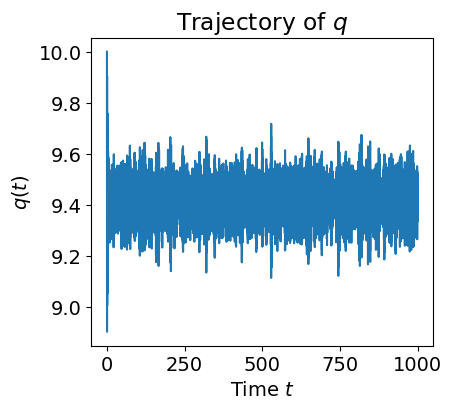

In [ ]:
q0, p0, h, gamma, beta, Nsteps = 10, 1, 0.1, 1, 1.0, 10000
q_traj, p_traj, t_traj = run_simulation(q0, p0, Nsteps , h, gamma, beta, ld_BAOAB, my_force)
fig = plt.figure(figsize=[15,4])
plt.subplot(1,3,1)
plt.plot(t_traj, q_traj)
plt.title('Trajectory of $q$')
plt.ylabel('$q(t)$')
plt.xlabel('Time $t$')

## **Discussion:** There are other ways initialization affects the sampling. If we place q0 in the well, it samples reasonably well. However, if we put it at two of the higher wells, it has heavier tails. This is because of the energy barrier effect.

BAOAB to compute observable averages for the following observable functions:
$$\varphi_1(q) = q^2$$
$$\varphi_2(q) = e^{-q^2}$$

In [ ]:
def phi_1(q):
    U= q**2
    return U

def phi_2(q):
    U = np.exp(-(q**2))
    return U

In [ ]:
q0, p0, h, gamma, beta, Nsteps = np.random.randn(1), np.random.randn(1), 0.1, 1, 1.0, 1000000
q_traj, p_traj, t_traj = run_simulation(q0, p0, Nsteps , h, gamma, beta, ld_BAOAB, my_force)

## We validate if $\mathbf{E}[\phi_1(q)]$ is sampled properly. That is, we are estimating $∫\phi_1(q)\pi(q)dq$ where $\pi(q)$ is the invariant measure. We recover the true $\mathbf{E}[\phi_1(q)]$ using numerical quadrature above. We use this to see if $\hat{\mathbf{E}}[\phi_1(q)]$ provides a reasonable approximation. However, we do not have the normalization constant of $\pi(q)$.

## We can compute this by $$Z_{\beta} = \int_{-\infty}^{\infty} exp(-\beta U(q)) dq = \int_{-\infty}^{\infty} exp(-q^2(.1+\sin^2(q))) dq$$

In [ ]:
def integrand_Z(q):
    return np.exp(-beta * my_pot(q))

# Perform the integration for Z_beta from -infinity to infinity
result, error = quad(integrand_Z, -np.inf, np.inf)

print('Z is: ' + str(result))

Z is: 2.459909992989273


## Then, $\pi(q) = \frac{1}{Z_{\beta}} exp(-\beta U(q))$

In [ ]:
Z_b = result
pi = lambda q: 1/Z_b * np.exp(-q**2 * (.1 + np.sin(q)**2))

## We first compute $\mathbf{E}[\phi_1(q)] = ∫\phi_1(q)\pi(q)dq$

## We then see how $\hat{\mathbf{E}}[\phi_1(q)] = \frac{1}{N} \Sigma q^2$ does relatively.

In [ ]:
E_phi1_true, _ = quad(lambda q: q**2 * pi(q), -np.inf, np.inf)
print("The true expectation wrt phi_1 is: " + str(E_phi1_true))
print("The estimated expectation wrt phi_1 is: " + str(np.mean(q_traj**2)))

The true expectation wrt phi_1 is: 2.353982441024815
The estimated expectation wrt phi_1 is: 2.2577686802839048


## We repeat the process for $\phi_2(q)$

In [ ]:
E_phi2_true, _ = quad(lambda q: phi_2(q) * pi(q), -np.inf, np.inf)
print("The true expectation wrt phi_2 is: " + str(E_phi2_true))
print("The estimated expectation wrt phi_2 is: " + str(np.mean(phi_2(q_traj))))

The true expectation wrt phi_2 is: 0.5653404265148825
The estimated expectation wrt phi_2 is: 0.562397208587215


## **Discussion:** We want to conduct further evaluation on this. Let us see how decreasing stepsize affects error.

In [ ]:
q0, p0, gamma, beta = np.random.randn(1), np.random.randn(1), 1, 1.0
hs = [0.1, 0.01, 0.001, 0.0001]
errors_1 = []
errors_2 = []
for h in hs:
  Nsteps = 100000 #100 * int(1/h)
  q_traj, p_traj, t_traj = run_simulation(q0, p0, Nsteps , h, gamma, beta, ld_BAOAB, my_force)
  errors_1.append(np.abs(E_phi1_true - np.mean(phi_1(q_traj))))
  errors_2.append(np.abs(E_phi2_true - np.mean(phi_2(q_traj))))

Text(0.5, 1.0, 'Absolute Error of Estimated Expectation of our Observable Functions')

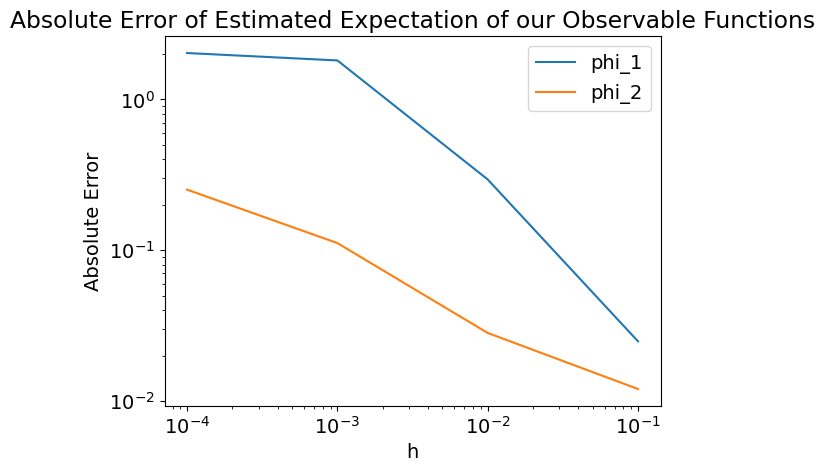

In [ ]:
plt.plot(hs, errors_1, label = 'phi_1')
plt.plot(hs, errors_2, label = 'phi_2')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.xlabel('h')
plt.ylabel('Absolute Error')
plt.title('Absolute Error of Estimated Expectation of our Observable Functions')

## We observe that for larger stepsizes, the absolute error decreases. This is most likely because for very small h, our trajectory is unable to sample the space efficiently and cross the energy barriers.

## We repeat the above experiment, but for a constant time (t=1000) rather than a constant number of steps.


Text(0.5, 1.0, 'Absolute Error of Estimated Expectation of our Observable Functions')

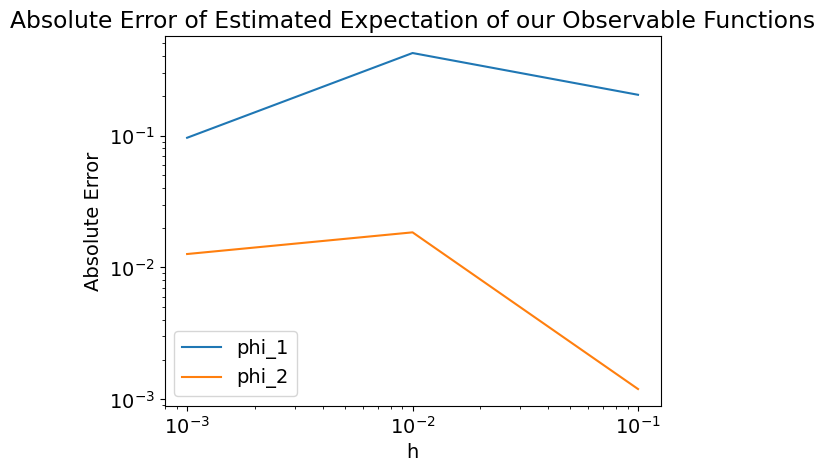

In [ ]:
q0, p0, gamma, beta = np.random.randn(1), np.random.randn(1), 1, 1.0
hs = [0.1, 0.01, 0.001]
errors_1 = []
errors_2 = []
for h in hs:
  Nsteps = 1000 * int(1/h)
  q_traj, p_traj, t_traj = run_simulation(q0, p0, Nsteps , h, gamma, beta, ld_BAOAB, my_force)
  errors_1.append(np.abs(E_phi1_true - np.mean(phi_1(q_traj))))
  errors_2.append(np.abs(E_phi2_true - np.mean(phi_2(q_traj))))
plt.plot(hs, errors_1, label = 'phi_1')
plt.plot(hs, errors_2, label = 'phi_2')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.xlabel('h')
plt.ylabel('Absolute Error')
plt.title('Absolute Error of Estimated Expectation of our Observable Functions')

# The UBU discretization
A recent paper https://arxiv.org/abs/2104.12384v2 highlighted the benefits of an alternative splitting of Langevin dynamics.  In this splitting, we divide the equations differently than in the A,B,O-based methods.

Instead of those components, the authors suggested

$$
\begin{pmatrix}
dq \\
dp
\end{pmatrix} = \underbrace{\begin{pmatrix}
0 \\
-\nabla U(q)dt
\end{pmatrix}}_{\mathcal{B}} +\underbrace{\begin{pmatrix}
pdt \\
-\gamma p dt + \sqrt{2\gamma}dW_t
\end{pmatrix}}_{\mathcal{U}},
$$

Each of $\mathcal{B}$, $\mathcal{U}$ can be integrated exactly, in the weak sense.  The first term is the same as the B in the A,B,O framework. Isolating the second part we have
$$
\begin{align}
{\rm d}q & = p {\rm d} t\\
{\rm d}p & = -\gamma p dt + \sqrt{2\gamma}dW_t
\end{align}
$$
and we see that the second equation is just the O-equation we had before. It follows that the step in $p$ is defined as above.  Then, as the other part of the $\mathcal{U}$ step, we need to evaluate $q$ as the integral of $p$ (in the setting of stochastic integration).  Given $\gamma > 0$, let $\eta = \exp{\left(-\gamma h\right)}$,let
\begin{equation}\label{eq:Bdef}
\mathcal{B}(q,p,h) = (q,p - h\nabla U(q)),
\end{equation}
and
\begin{equation}\label{eq:Udef}
\begin{split}
\mathcal{U}(q,p,h,\xi^{(1)},\xi^{(2)}) &= \Big(q + \frac{1-\exp{\left(-\gamma h\right)}}{\gamma}p + \sqrt{\frac{2}{\gamma}}\left(\mathcal{Z}^{(1)}\left(h,\xi^{(1)}\right) - \mathcal{Z}^{(2)}\left(h,\xi^{(1)},\xi^{(2)}\right) \right),\\
& v\exp{\left(-\gamma h\right)} + \sqrt{2\gamma}\mathcal{Z}^{(2)}\left(h,\xi^{(1)},\xi^{(2)}\right)\Big),
\end{split}
\end{equation}
where
\begin{equation}\label{eq:Z12def}
\begin{split}
\mathcal{Z}^{(1)}\left(h,\xi^{(1)}\right) &= \sqrt{h}\xi^{(1)},\\
\mathcal{Z}^{(2)}\left(h,\xi^{(1)},\xi^{(2)}\right) &= \sqrt{\frac{1-\eta^{2}}{2\gamma}}\Bigg(\sqrt{\frac{1-\eta}{1+\eta}\cdot \frac{2}{\gamma h}}\xi^{(1)} + \sqrt{1-\frac{1-\eta}{1+\eta}\cdot\frac{2}{\gamma h}}\xi^{(2)}\Bigg).
\end{split}
\end{equation}
The $\mathcal{B}$ operator indicated here is as given previously, whereas $\mathcal{U}$ as defined above is the exact solution in the weak sense of the remainder of the dynamics when  $\xi^{(1)}, \xi^{(2)} \sim \mathcal{N}\left(0,I_{d}\right)$ are independent random vectors.

As before, we can have different sequences, for example applying $\mathcal{B}$ then $\mathcal{U}$, each for a stepsize $h$.  Or more complicated combinations of the parts like UBU  are possible which is a half a U step, then a full B step, then half a U step.

In [ ]:
def U_step(qp, h, force, gamma):
    q,p = qp
    F = force(q)
    normal_1 = np.random.randn(q.shape[0]).reshape(q.shape[0])
    normal_2 = np.random.randn(q.shape[0]).reshape(q.shape[0])
    eta = np.exp(-gamma*h)
    frac = (1-eta)/(1+eta)
    Z_1 = np.sqrt(h) * normal_1
    Z_2 = np.sqrt((1-eta**2)/(2 * gamma)) * np.sqrt(frac* (2/(gamma*h))) * normal_1 + np.sqrt(1-frac * (2/(gamma*h))) * normal_2
    coeff_1 = (1-eta)/gamma
    q = q + coeff_1 * p + np.sqrt(2/gamma) * (Z_1-Z_2)
    p = p * eta + np.sqrt(2*gamma) * Z_2
    return [q,p]

def B_step(qp, h, force):
    q,p = qp
    F = force(q)
    p = p + h * force(q)
    return [q,p]

def ld_UBU(q,p,h,gamma,beta, force):
    qp = np.copy([q,p])
    # your code goes here
    qp = U_step(qp, h/2, force, gamma)
    qp = B_step(qp, h, force)
    qp = U_step(qp, h/2, force, gamma)

    q,p = qp

    return q , p

## $U(q) = q^2/2$

In [ ]:
q0, p0, h, gamma, beta, Nsteps = np.random.randn(1), np.random.randn(1), 0.1, 1, 1.0, 100000
q_traj_UBU, p_traj_UBU, t_traj_UBU = run_simulation(q0, p0, Nsteps , h, gamma, beta, ld_UBU, force_Gaussian)
q_traj_BAOAB, p_traj_BAOAB, t_traj_BAOAB = run_simulation(q0, p0, Nsteps , h, gamma, beta, ld_BAOAB, force_Gaussian)

def integrand_Z(q):
    return np.exp(-beta * q**2 / 2)

# Perform the integration for Z_beta from -infinity to infinity
result, error = quad(integrand_Z, -np.inf, np.inf)
Z_b = result
pi = lambda q: 1/Z_b * np.exp(-q**2 / 2)
E_true_gaussian, _ = quad(lambda q: q * pi(q), -np.inf, np.inf)
E_phi1_true_gaussian, _ = quad(lambda q: q**2 * pi(q), -np.inf, np.inf)
E_phi2_true_gaussian, _ = quad(lambda q: phi_2(q) * pi(q), -np.inf, np.inf)

In [ ]:
pd.DataFrame({'Observable Function':['E[q]', 'E[q^2]', 'E[phi_2(q)]'], 'Truth': [E_true_gaussian, E_phi1_true_gaussian, E_phi2_true_gaussian],
              'UBU': [np.mean(q_traj_UBU), np.mean(q_traj_UBU**2), np.mean(phi_2(q_traj_UBU))],
              'BAOAB': [np.mean(q_traj_BAOAB), np.mean(q_traj_BAOAB**2), np.mean(phi_2(q_traj_BAOAB))]})

,Observable Function,Truth,UBU,BAOAB
0,E[q],0.00000,0.016248,-0.001720
1,E[q^2],1.00000,0.987958,0.962557
2,E[phi_2(q)],0.57735,0.580727,0.583191


## **Discussion:** Both methods appear to give reasonable approximations. BAOAB is clearly an order of magnitude better for $E[q]$. They are relatively the same for $E[q^2]$ and $E[\phi_2(q)]$.

## $U(q) = q^2(.1+\sin^2(q))$

In [ ]:
q0, p0, h, gamma, beta, Nsteps = np.random.randn(1), np.random.randn(1), 0.1, 1, 1.0, 100000
q_traj_UBU, p_traj_UBU, t_traj_UBU = run_simulation(q0, p0, Nsteps , h, gamma, beta, ld_UBU, my_force)
q_traj_BAOAB, p_traj_BAOAB, t_traj_BAOAB = run_simulation(q0, p0, Nsteps , h, gamma, beta, ld_BAOAB, my_force)

def integrand_Z(q):
    return np.exp(-beta * my_pot(q))

result, error = quad(integrand_Z, -np.inf, np.inf)
Z_b = result
pi = lambda q: 1/Z_b * np.exp(-q**2 * (.1 + np.sin(q)**2))
E_true_sin, _ = quad(lambda q: q * pi(q), -np.inf, np.inf)
E_phi1_true_sin, _ = quad(lambda q: q**2 * pi(q), -np.inf, np.inf)
E_phi2_true_sin, _ = quad(lambda q: phi_2(q) * pi(q), -np.inf, np.inf)

pd.DataFrame({'Observable Function':['E[q]', 'E[q^2]', 'E[phi_2(q)]'], 'Truth': [E_true_sin, E_phi1_true_sin, E_phi2_true_sin],
              'UBU': [np.mean(q_traj_UBU), np.mean(q_traj_UBU**2), np.mean(phi_2(q_traj_UBU))],
              'BAOAB': [np.mean(q_traj_BAOAB), np.mean(q_traj_BAOAB**2), np.mean(phi_2(q_traj_BAOAB))]})

,Observable Function,Truth,UBU,BAOAB
0,E[q],0.000000,-0.079389,0.108559
1,E[q^2],2.353982,2.406410,2.135749
2,E[phi_2(q)],0.565340,0.551245,0.571724


## **Discussion:** They both appear to perform relatively the same. On one hand, UBU underestimates while BAOAB overestimates. I wonder if this is a characteristic of the methods. We will study this further in the next part. Note that results are most likely sensitive to initialization. It really depends around which critical point it is initialized around. Also, it will take more realizations for a particular configuration averaged over to make sturdy conclusions about whether one method is better than the other.

In [ ]:
hs = [1.0, 0.1, 0.01, 0.001, 0.0001]
UBUs_1, UBUs_2, UBUs_3 = [], [], []
BAOABs_1, BAOABs_2, BAOABs_3 = [], [], []
for i,h in enumerate(hs):
  Nsteps = 10000
  q_traj_BAOAB, p_traj_BAOAB, t_traj_BAOAB = run_simulation(q0, p0, Nsteps , h, gamma, beta, ld_BAOAB, force_Gaussian)
  q_traj_UBU, p_traj_UBU, t_traj_UBU = run_simulation(q0, p0, Nsteps , h, gamma, beta, ld_UBU, force_Gaussian)
  UBUs_1.append(np.abs(E_true_gaussian - np.mean(q_traj_UBU)))
  BAOABs_1.append(np.abs(E_true_gaussian - np.mean(q_traj_BAOAB)))
  UBUs_2.append(np.abs(E_phi1_true_gaussian -  np.mean(q_traj_UBU**2)))
  BAOABs_2.append(np.abs(E_phi1_true_gaussian -  np.mean(q_traj_BAOAB**2)))
  UBUs_3.append(np.abs(E_phi2_true_gaussian -  np.mean(phi_2(q_traj_UBU))))
  BAOABs_3.append(np.abs(E_phi2_true_gaussian -  np.mean(phi_2(q_traj_BAOAB))))

## $E(q)$

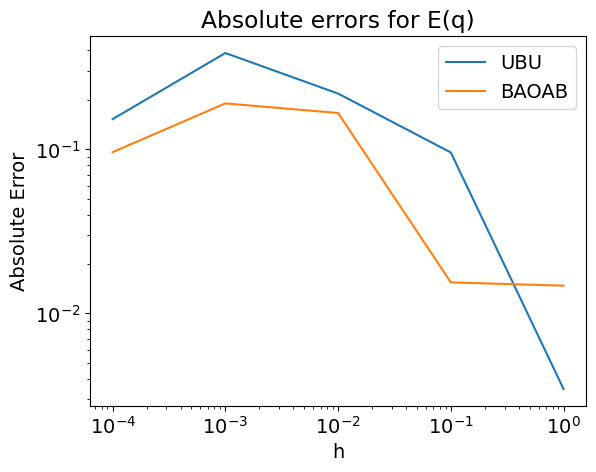

In [ ]:
plt.plot(hs, UBUs_1, label = 'UBU')
plt.plot(hs, BAOABs_1, label = 'BAOAB')
plt.legend()
plt.title('Absolute errors for E(q)')
plt.xlabel('h')
plt.ylabel('Absolute Error')
plt.yscale('log')
plt.xscale('log')
plt.show()

## **Discussion:** BAOAB appears to do better overall. UBU does appear to be better at h=1 but this may just be due to random variation. We would probably get more consistent results if we averaged over 10 trajectories. However, this takes a long time to run so we do not implement it. It is also possible that UBU does better for h > 1.

## $E(q^2)$

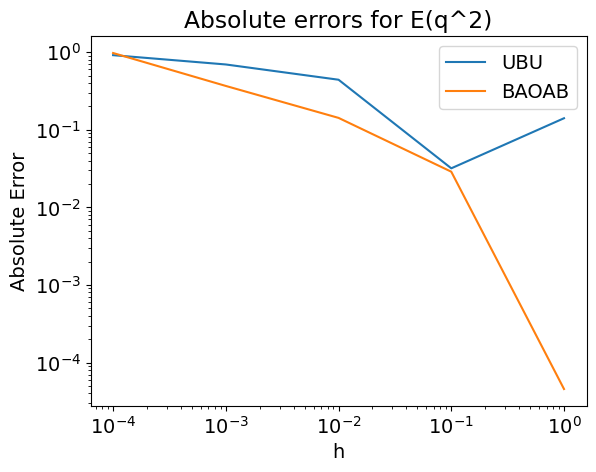

In [ ]:
plt.plot(hs, UBUs_2, label = 'UBU')
plt.plot(hs, BAOABs_2, label = 'BAOAB')
plt.legend()
plt.title('Absolute errors for E(q^2)')
plt.xlabel('h')
plt.ylabel('Absolute Error')
plt.yscale('log')
plt.xscale('log')
plt.show()


## **Discussion:** BAOAB appears to do better overall. They appear to be the same at h=0.1 but this may just be due to random variation. We would probably get more consistent results if we averaged over 10 trajectories. However, this takes a long time to run so we do not implement it. This is a result of the theoretical difference in discretization errors for the two methods. It is not entirely clear from the plots however. We would need more points and more realizations.

## $E(\phi_2(q))$

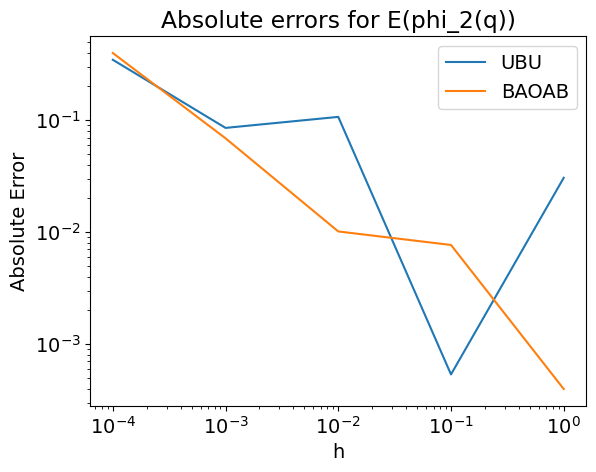

In [ ]:
plt.plot(hs, UBUs_3, label = 'UBU')
plt.plot(hs, BAOABs_3, label = 'BAOAB')
plt.legend()
plt.title('Absolute errors for E(phi_2(q))')
plt.xlabel('h')
plt.ylabel('Absolute Error')
plt.yscale('log')
plt.xscale('log')
plt.show()

## **Discussion:** BAOAB appears to do better for smaller stepsizes and consistently goes down. UBU seems to be pretty inconsistent. Perhaps these plots are not sufficient to understand what is going on. We want to further study our hypothesis in the next part using Integrated Autocorrelation Time.


In [ ]:
#Source: https://rstudio-pubs-static.s3.amazonaws.com/258436_5c7f6f9a84bd47aeaa33ee763e57a531.html

def auto_corr_fast(M, lag = 200): # FFT to compute autocorrelation efficiently
    M = M - np.mean(M)
    N = len(M)
    fvi = np.fft.fft(M, n=2*N)
    G = np.real( np.fft.ifft( fvi * np.conjugate(fvi) )[:N] )
    G /= N - np.arange(N); G /= G[0]
    G = G[:lag]
    return G

def tau(M, lag = 200):
    autocorr = auto_corr_fast(M, lag)
    return 1 + 2*np.sum(autocorr), autocorr

# $U(q) = q^2 / 2$

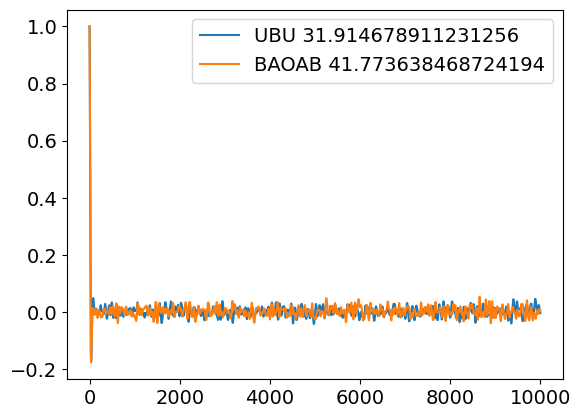

In [ ]:
q0, p0, h, gamma, beta, Nsteps = np.random.randn(1), np.random.randn(1), 0.1, 1, 1.0, 100000
q_traj_UBU, p_traj_UBU, t_traj_UBU = run_simulation(q0, p0, Nsteps , h, gamma, beta, ld_UBU, force_Gaussian)
q_traj_BAOAB, p_traj_BAOAB, t_traj_BAOAB = run_simulation(q0, p0, Nsteps , h, gamma, beta, ld_BAOAB, force_Gaussian)
tau_UBU, acor_UBU = tau(q_traj_UBU.reshape(-1), lag = 10000)
tau_BAOAB, acor_BAOAB = tau(q_traj_BAOAB.reshape(-1), lag = 10000)
plt.plot(np.arange(len(acor_UBU)),acor_UBU,label='UBU ' + str(tau_UBU))
plt.plot(np.arange(len(acor_BAOAB)),acor_BAOAB,label='BAOAB ' + str(tau_BAOAB))
plt.legend()

## **Discussion:** IAT is the number of correlated samples with the same variance-reducing power as one independent sample. A lower IAT is better. We obtain an IAT of 27.09 for UBU and 27.17 for BAOAB. The autocorrelation curves for lag = 2000 appear to be relatively similar. I do not think that there is much of a difference in convergence of the 2 methods for h = 0.1. This is consistent with my statement earlier that for larger stepsizes, there is not much of a difference in convergence. Let us try it for a smaller stepsize. This is most likely also sensitive to initialization. In our case, we have q0 = -0.06.

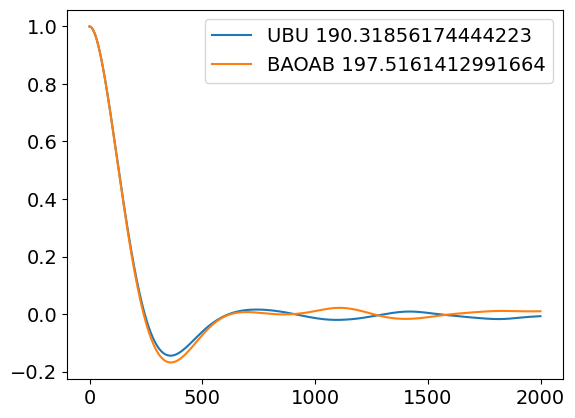

In [ ]:
h, gamma, beta, Nsteps = 0.01, 1, 1.0, 1000000
q_traj_UBU, p_traj_UBU, t_traj_UBU = run_simulation(q0, p0, Nsteps , h, gamma, beta, ld_UBU, force_Gaussian)
q_traj_BAOAB, p_traj_BAOAB, t_traj_BAOAB = run_simulation(q0, p0, Nsteps , h, gamma, beta, ld_BAOAB, force_Gaussian)
tau_UBU, acor_UBU = tau(q_traj_UBU.reshape(-1), lag = 2000)
tau_BAOAB, acor_BAOAB = tau(q_traj_BAOAB.reshape(-1), lag = 2000)
plt.plot(np.arange(len(acor_UBU)),acor_UBU,label='UBU ' + str(tau_UBU))
plt.plot(np.arange(len(acor_BAOAB)),acor_BAOAB,label='BAOAB ' + str(tau_BAOAB))
plt.legend()

## **Discussion:** The autocorrelation curves still appear quite similar. However, UBU has a slightly lower IAT for this stepsize. This might indicate that for this energy function and lower stepsizes, UBU performs better? It would be wise to take the average of several trajectories to verify that this is not due to random variation. But due to time constraints, we will not be delving into that. We normally would also take into account burn-in, but since it is initialized in a region of high energy already, I dont think it would make a difference.

# $U(q) = q^2(.1 + sin^2(q))$

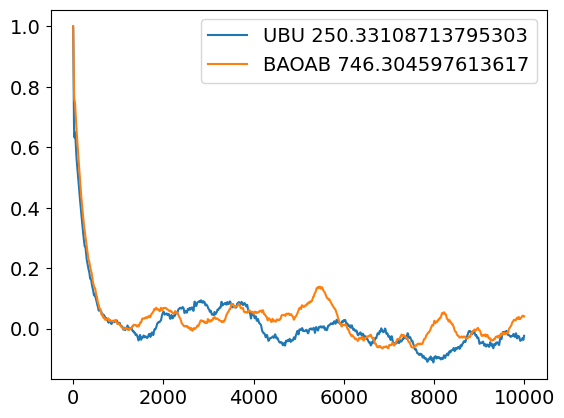

In [ ]:
q0, p0, h, gamma, beta, Nsteps = np.random.randn(1), np.random.randn(1), 0.1, 1, 1.0, 100000
q_traj_UBU, p_traj_UBU, t_traj_UBU = run_simulation(q0, p0, Nsteps , h, gamma, beta, ld_UBU, my_force)
q_traj_BAOAB, p_traj_BAOAB, t_traj_BAOAB = run_simulation(q0, p0, Nsteps , h, gamma, beta, ld_BAOAB, my_force)
tau_UBU, acor_UBU = tau(q_traj_UBU.reshape(-1), lag = 10000)
tau_BAOAB, acor_BAOAB = tau(q_traj_BAOAB.reshape(-1), lag = 10000)
plt.plot(np.arange(len(acor_UBU)),acor_UBU,label='UBU ' + str(tau_UBU))
plt.plot(np.arange(len(acor_BAOAB)),acor_BAOAB,label='BAOAB ' + str(tau_BAOAB))
plt.legend()

## **Discussion**: Notice how the correlation between samples appear to be much higher compared to the previous density. This is most likely because of the nature of the density having energy barriers. Note that q0 = -0.1 in this case. I expect to get diffferent results for initializations in other critical points of the well potential. UBU appears to be quite a bit better than BAOAB when inspecting the IATs. Let us see if this is the case for smaller stepsize. Regardless, both of them are doing quite poorly.

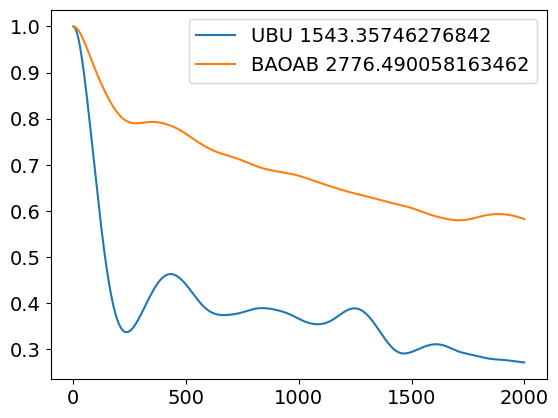

In [ ]:
h, gamma, beta, Nsteps = 0.01, 1, 1.0, 100000
q_traj_UBU, p_traj_UBU, t_traj_UBU = run_simulation(q0, p0, Nsteps , h, gamma, beta, ld_UBU, my_force)
q_traj_BAOAB, p_traj_BAOAB, t_traj_BAOAB = run_simulation(q0, p0, Nsteps , h, gamma, beta, ld_BAOAB, my_force)
tau_UBU, acor_UBU = tau(q_traj_UBU.reshape(-1), lag = 2000)
tau_BAOAB, acor_BAOAB = tau(q_traj_BAOAB.reshape(-1), lag = 2000)
plt.plot(np.arange(len(acor_UBU)),acor_UBU,label='UBU ' + str(tau_UBU))
plt.plot(np.arange(len(acor_BAOAB)),acor_BAOAB,label='BAOAB ' + str(tau_BAOAB))
plt.legend()

## **Discussion:** Once again UBU seems to perform better for smaller stepsize. We would have to validate this by averaging over several trajectories, and inspecting the autocorrelation curves at different initializations and more stepsizes for a more detailed systematic study. But we will leave it at this from now. Based on our results, I would conclude that BAOAB performs better for smaller stepsizes. The gap between the two IATs has increased relative to each other by quite a bit. Notice how the magnitude of IATs have increasd. This is to be expected as the stepsizes are so small that they can't help but be highly correlated between neighboring steps.